In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import copy

%matplotlib inline

from plotting import plot_utils, pycortex_plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_all_font_sizes(16)
from utils import roi_utils, default_paths, stats_utils

In [16]:
# Load results of the fitting procedure

subject = 1
volume_space=True
feature_type_list_long = ['clip_RN50_best_layer_pca']
feature_type_list = ['clip']
nf = [0]

for fi, fitting_type in enumerate(feature_type_list_long):
    out= load_fits.load_fit_results(subject, fitting_type,n_from_end=nf[fi],verbose=True);

    if fi==0:
        n_voxels = out['sem_corr_each_axis'].shape[0]
        n_discrim_types = out['sem_discrim_each_axis'].shape[1]
        sem_corr = np.zeros((len(feature_type_list), n_discrim_types, n_voxels))
        sem_discrim = np.zeros((len(feature_type_list), n_discrim_types, n_voxels))
        clip_r2 = np.zeros((n_voxels,))
        discrim_type_list = out['discrim_type_list']
        
    sem_corr[fi,:,:] = out['sem_corr_each_axis'].T
    sem_discrim[fi,:,:] = out['sem_discrim_each_axis'].T
    
    if fi==0:
        n_samp = out['n_sem_samp_each_axis']
    else:
        try:
            n_samp2 = out['n_sem_samp_each_axis']
            assert(np.all(n_samp[~np.isnan(n_samp)]==n_samp2[~np.isnan(n_samp2)]))
        except:
            print('n_sem_samp field is missing')    
                
    # take out any pRFs/semantic axes where there were fewer than 10 val set trials
    # that had defined labels, because t-stats won't be very stable.
    for aa in range(n_discrim_types):

        min_samp = 10
        
        exclude_vox = np.any(n_samp[:,aa,:]<min_samp, axis=1)
#         print('excluding %d vox'%np.sum(exclude_vox))
        sem_corr[fi,aa,exclude_vox] = np.nan
        sem_discrim[fi,aa,exclude_vox] = np.nan
    
    if 'clip' in fitting_type:
        clip_r2 = out['val_r2'][:,0]

np.all(np.isnan(sem_discrim)==np.isnan(sem_corr))
sem_discrim[np.isinf(sem_discrim)] = np.nan

which_prf_grid=5
top_two_fn = os.path.join(default_paths.stim_labels_root, \
                           'Coco_supcat_top_two_prf_grid%d.npy'%(which_prf_grid))
top_two = np.load(top_two_fn, allow_pickle=True).item()

roi_def = roi_utils.nsd_roi_def(subject, verbose=False)

save_name_groups = os.path.join(default_paths.stim_labels_root,'All_concat_labelgroupnames.npy')
groups = np.load(save_name_groups, allow_pickle=True).item()

loading from /user_data/mmhender/imStat/model_fits/S01/clip_RN50_best_layer_pca/Feb-05-2022_2058_34/all_fit_params.npy

dict_keys(['subject', 'volume_space', 'fitting_types', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'ridge', 'debug', 'up_to_sess', 'single_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'saved_prfs_fn', 'best_layer_each_voxel', 'saved_best_layer_fn', 'voxel_subset_is_done_trn', 'voxel_subset_is_done_val', 'corr_each_feature', 'sem_discrim_each_axis', 'sem_corr_each_axis', 'discrim_type_list', 'n_sem_samp_each_axis', 'clip_layer_name', 'clip_model_architecture', 'use_pca_clip_feats'])


In [19]:
groups['col_names_all']

[['has_indoor', 'has_outdoor'],
 ['has_natural', 'has_humanmade'],
 ['has_animate', 'has_inanimate'],
 ['has_small', 'has_large'],
 ['has_accessory', 'has_other'],
 ['has_animal', 'has_other'],
 ['has_appliance', 'has_other'],
 ['has_electronic', 'has_other'],
 ['has_food', 'has_other'],
 ['has_furniture', 'has_other'],
 ['has_indoor', 'has_other'],
 ['has_kitchen', 'has_other'],
 ['has_outdoor', 'has_other'],
 ['has_person', 'has_other'],
 ['has_sports', 'has_other'],
 ['has_vehicle', 'has_other'],
 ['umbrella', 'suitcase'],
 ['cat', 'dog'],
 ['oven', 'refrigerator'],
 ['tv', 'laptop'],
 ['pizza', 'cake'],
 ['dining table', 'bed'],
 ['teddy bear', 'vase'],
 ['bowl', 'cup'],
 ['bench', 'fire hydrant'],
 ['surfboard', 'kite'],
 ['train', 'bus'],
 ['has_building', 'has_other'],
 ['has_ceiling', 'has_other'],
 ['has_floor', 'has_other'],
 ['has_food-stuff', 'has_other'],
 ['has_furniture-stuff', 'has_other'],
 ['has_ground', 'has_other'],
 ['has_other', 'has_other'],
 ['has_plant', 'has_o

In [11]:
np.min(n_samp[:,0:4,:], axis=0)

array([[ 729., 2079.],
       [1050.,  642.],
       [  33.,  126.],
       [  21.,   99.]], dtype=float32)

(19738, 21)
(19738, 21)


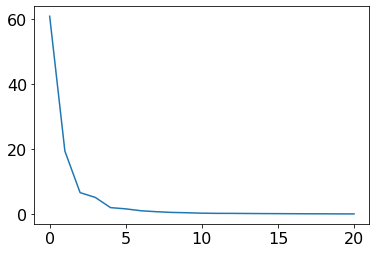

In [3]:
from sklearn import decomposition

values = copy.deepcopy(sem_discrim[0,:,:])
n_bad_axes = np.sum(np.isnan(values), axis=0)
vox2keep = np.where(n_bad_axes<60)[0]
values_adj = values[:,vox2keep]
values_adj.shape
axes2keep = np.where(~np.any(np.isnan(values_adj), axis=1))[0]
axes2keep.shape
values_adj = values_adj[axes2keep,:]
values_adj.shape
assert not np.any(np.isnan(values_adj))

pca = decomposition.PCA()
print(values_adj.T.shape)
scores = pca.fit_transform(values_adj.T) 
print(scores.shape)
wts = pca.components_
ev = pca.explained_variance_
ev = ev/np.sum(ev)*100

plt.figure();
plt.plot(ev)

n_vox = sem_discrim.shape[2]
n_pc2plot = 4;
scores_in_mask = np.full((n_vox,n_pc2plot), fill_value=np.nan)
scores_in_mask[vox2keep,:] = scores[:,0:n_pc2plot]

In [5]:
# make some groups (averaging over all superord or basic level discrims)

inds2group = [[0], [1], [2], [3], np.arange(4,16), np.arange(27,43), np.arange(16,27), np.arange(43,55)]
group_names = [discrim_type_list[ii] for ii in [0,1,2,3]] + \
                ['things-superord','stuff-superord' ,'things-basic', 'stuff-basic']

n_vox = sem_discrim.shape[2]
sem_discrim_grouped = np.zeros((len(inds2group), n_vox))
for gg, inds in enumerate(inds2group):
    sem_discrim_grouped[gg,:] = np.nanmean(np.abs(sem_discrim[fi,inds,:]), axis=0)
    print(group_names[gg])
    print(np.array(discrim_type_list)[inds])

indoor_outdoor
['indoor_outdoor']
natural_humanmade
['natural_humanmade']
animacy
['animacy']
real_world_size
['real_world_size']
things-superord
['accessory' 'animal' 'appliance' 'electronic' 'food' 'furniture' 'indoor'
 'kitchen' 'outdoor' 'person' 'sports' 'vehicle']
stuff-superord
['building' 'ceiling' 'floor' 'food-stuff' 'furniture-stuff' 'ground'
 'other' 'plant' 'raw-material' 'sky' 'solid' 'structural' 'textile'
 'wall' 'water' 'window']
things-basic
['within_accessory' 'within_animal' 'within_appliance' 'within_electronic'
 'within_food' 'within_furniture' 'within_indoor' 'within_kitchen'
 'within_outdoor' 'within_sports' 'within_vehicle']
stuff-basic
['within_building' 'within_floor' 'within_food-stuff'
 'within_furniture-stuff' 'within_ground' 'within_plant'
 'within_raw-material' 'within_solid' 'within_structural' 'within_textile'
 'within_wall' 'within_water']


/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


In [15]:
import cortex

port=44442

vox2plot = clip_r2>0.01

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out, screen_eccen_deg=8.4)

names = ['pRF eccentricity (from alexnet FWRF)', 'pRF angle (from alexnet FWRF)', \
         'pRF size (from alexnet FWRF)', \
        'R2 for CLIP best layer fit']
maps = [best_ecc_deg, best_angle_deg, best_size_deg, np.sqrt(clip_r2)]
cmaps = ['PRGn', 'Retinotopy_RYBCR', 'PRGn', 'PuBu']
mins = [0,0,0, 0]
maxes = [7, 360, 4, 0.8]

dd2plot = np.where([not 'within' in name for name in discrim_type_list])[0]

for dd in dd2plot:
    
    name = discrim_type_list[dd]
    names += ['%s discriminability (t-statistic)'%(name)]
    tvals = copy.deepcopy(sem_discrim[0,dd,:])
    maps += [(-1)*tvals]
    mins += [-20]
    maxes += [20]
    cmaps += ['RdBu']
    
    if name in top_two['stuff_top_two'].keys():
        sub_names = top_two['stuff_top_two'][name]
    elif name in top_two['things_top_two'].keys():
        sub_names = top_two['things_top_two'][name]
    else:
        sub_names=[]
        
    if len(sub_names)>0:
        
        within_ind = np.where(['within_%s'%name==dname for dname in discrim_type_list])[0][0]
        # since we invert the t-statistic - it reflects label 0 being > label 1
        names += ['%s > %s'%(sub_names[0], sub_names[1])]
        within_tvals = copy.deepcopy(sem_discrim[0,within_ind,:]) 
        maps += [(-1)*within_tvals]
        mins += [-10]
        maxes += [10]
        cmaps += ['RdBu']
        
        names += ['%s vs %s (thresh)'%(sub_names[0], sub_names[1])]
        vals_masked = copy.deepcopy(within_tvals)
        vals_masked[tvals>(-5)] = np.nan
        maps += [(-1)*vals_masked]
        mins += [-10]
        maxes += [10]
        cmaps += ['RdBu']

for gi, gname in enumerate(group_names): 
    
    if gi<4:
        continue
    
    names += ['avg abs ' + gname]
    tvals = copy.deepcopy(sem_discrim_grouped[gi,:])
    maps += [tvals]
    mins += [0]
    maxes += [10]
    cmaps += ['PuBu']
    
for pc in range(n_pc2plot): 
  
    names += ['pc %d'%(pc+1)]
    maps += [(scores_in_mask[:,pc] - np.nanmean(scores_in_mask[:,pc]))/np.nanstd(scores_in_mask[:,pc])]
    mins += [-10]
    maxes += [10]
    cmaps += ['RdBu']
        
pycortex_plot_utils.plot_maps_pycortex(subject, title=fitting_type, port=port, maps=maps, names=names, roi_def=roi_def, \
                       mins=mins, maxes=maxes, cmaps=cmaps, vox2plot=vox2plot)

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


Data is in 3d volume space
navigate browser to: 127.0.0.1:44442
Started server on port 44442


In [12]:
import scipy.stats
(scores_in_mask[:,pc] - np.nanmean(scores_in_mask[:,pc]))/np.nanstd(scores_in_mask[:,pc])

array([ 0.27162203, -1.48040657,  0.88104825, ...,  0.09942192,
       -0.92890569, -0.42868381])

<Figure size 864x288 with 0 Axes>

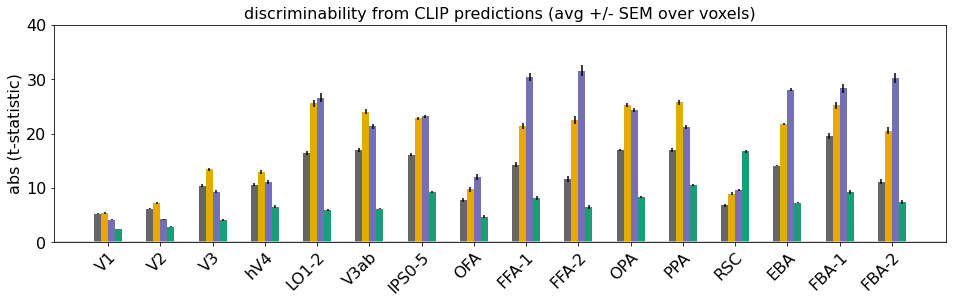

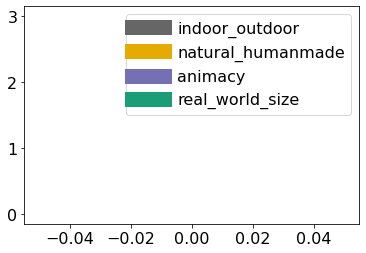

In [6]:
# plot abs tstat for higher-level categories

roi_names =roi_def.roi_names
skip_inds = [4,5,7,10,11,15,16,23]
areas2plot = np.arange(len(roi_names))
areas2plot = areas2plot[~np.isin(areas2plot, skip_inds)]

dd2plot = [0,1,2,3]
discrim_type_colors = np.flipud(cm.Dark2(np.linspace(0,1,len(dd2plot))))
   
vox2use = clip_r2>0.01

plt.figure(figsize=(12,4));

vals = np.abs(sem_discrim[0,dd2plot,:])

mean_vals = np.zeros((len(areas2plot), len(dd2plot)))
sem_vals = np.zeros((len(areas2plot), len(dd2plot)))
for ri, rr in enumerate(areas2plot):
    
    inds_this_roi = roi_def.get_indices(rr) & vox2use

    vals_this_roi = vals[:,inds_this_roi]
    mean_vals[ri,:] = np.mean(vals_this_roi, axis=1)
    sem_vals[ri,:] = np.std(vals_this_roi, axis=1)/np.sqrt(np.sum(inds_this_roi))

legend_separate=True
title = 'discriminability from CLIP predictions (avg +/- SEM over voxels)'

plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=discrim_type_colors, space=0.3, \
                xticklabels=np.array(roi_names)[areas2plot], ylabel='abs (t-statistic)', \
                ylim=[0, 40], title=title, horizontal_line_pos=0,\
                legend_labels=np.array(discrim_type_list)[dd2plot], \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))

    

<Figure size 864x288 with 0 Axes>

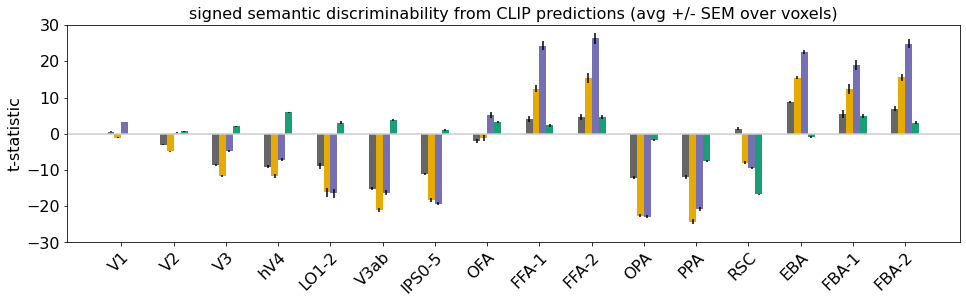

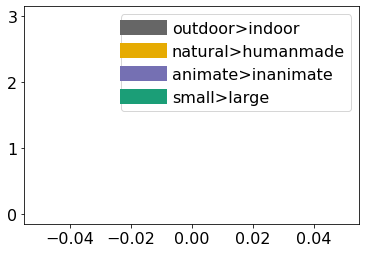

In [20]:
# signed t-stat


roi_names =roi_def.roi_names
skip_inds = [4,5,7,10,11,15,16,23]
areas2plot = np.arange(len(roi_names))
areas2plot = areas2plot[~np.isin(areas2plot, skip_inds)]

dd2plot = [0,1,2,3]
discrim_type_colors = np.flipud(cm.Dark2(np.linspace(0,1,len(dd2plot))))
names = copy.deepcopy(np.array(discrim_type_list)[dd2plot])
names[0] = 'outdoor>indoor'
names[1] = 'natural>humanmade'
names[2] = 'animate>inanimate'
names[3] = 'small>large'

vox2use = clip_r2>0.01

plt.figure(figsize=(12,4));

vals = copy.deepcopy(sem_discrim[0,dd2plot,:])
vals = vals*(-1)
vals[0,:] = (-1)*vals[0,:]

mean_vals = np.zeros((len(areas2plot), len(dd2plot)))
sem_vals = np.zeros((len(areas2plot), len(dd2plot)))
for ri, rr in enumerate(areas2plot):
    
    inds_this_roi = roi_def.get_indices(rr) & vox2use

    vals_this_roi = vals[:,inds_this_roi]
    mean_vals[ri,:] = np.mean(vals_this_roi, axis=1)
    sem_vals[ri,:] = np.std(vals_this_roi, axis=1)/np.sqrt(np.sum(inds_this_roi))

legend_separate=True
title = 'signed semantic discriminability from CLIP predictions (avg +/- SEM over voxels)'

plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=discrim_type_colors, space=0.3, \
                xticklabels=np.array(roi_names)[areas2plot], ylabel='t-statistic', \
                ylim=[-30,30], title=title, horizontal_line_pos=0,\
                legend_labels=names, \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))

    

<Figure size 864x288 with 0 Axes>

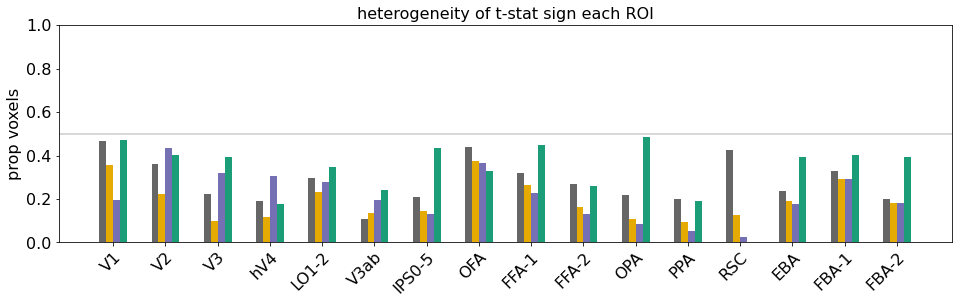

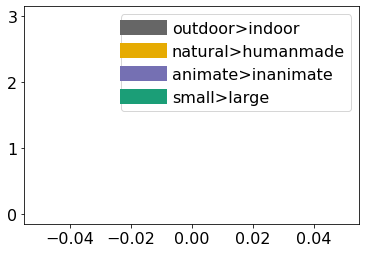

In [13]:
# heterogeneity of signs - minimum of [prop positive tstat vals, prop negative tstat vals]

roi_names =roi_def.roi_names
skip_inds = [4,5,7,10,11,15,16,23]
areas2plot = np.arange(len(roi_names))
areas2plot = areas2plot[~np.isin(areas2plot, skip_inds)]

dd2plot = [0,1,2,3]
discrim_type_colors = np.flipud(cm.Dark2(np.linspace(0,1,len(dd2plot))))
names = copy.deepcopy(np.array(discrim_type_list)[dd2plot])
names[0] = 'outdoor>indoor'
names[1] = 'natural>humanmade'
names[2] = 'animate>inanimate'
names[3] = 'small>large'

vox2use = clip_r2>0.01

plt.figure(figsize=(12,4));

vals = sem_discrim[0,dd2plot,:]

prop_sign_vals = np.zeros((len(areas2plot), len(dd2plot)))
for ri, rr in enumerate(areas2plot):
    
    inds_this_roi = roi_def.get_indices(rr) & vox2use
    vals_this_roi = vals[:,inds_this_roi]
    
    for di in range(len(dd2plot)):
        prop_neg = np.mean(vals_this_roi[di,:]<0)
        prop_pos = np.mean(vals_this_roi[di,:]>0)
        prop_sign_vals[ri,di] = np.min([prop_neg, prop_pos])
    
legend_separate=True
title = 'heterogeneity of t-stat sign each ROI'

plot_utils.plot_multi_bars(mean_data=prop_sign_vals, err_data=None, colors=discrim_type_colors, space=0.3, \
                xticklabels=np.array(roi_names)[areas2plot], ylabel='prop voxels', \
                ylim=[0,1], title=title, horizontal_line_pos=0.5,\
                legend_labels=names, \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))

    

<Figure size 864x288 with 0 Axes>

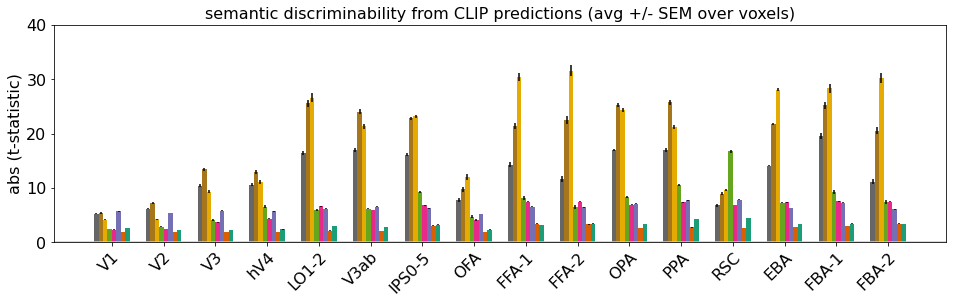

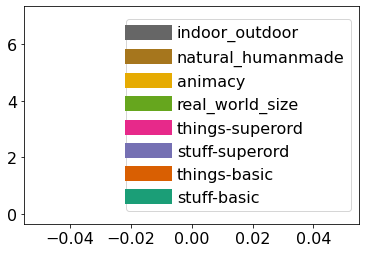

In [14]:
# plot discriminability for all the different levels of categorization

roi_names =roi_def.roi_names
skip_inds = [4,5,7,10,11,15,16,23]
areas2plot = np.arange(len(roi_names))
areas2plot = areas2plot[~np.isin(areas2plot, skip_inds)]

dd2plot = [0,1,2,3,4,5,6,7]
discrim_type_colors = np.flipud(cm.Dark2(np.linspace(0,1,len(dd2plot))))

vox2use = clip_r2>0.01

plt.figure(figsize=(12,4));

vals = np.abs(sem_discrim_grouped[dd2plot,:])

mean_vals = np.zeros((len(areas2plot), len(dd2plot)))
sem_vals = np.zeros((len(areas2plot), len(dd2plot)))
for ri, rr in enumerate(areas2plot):
    
    inds_this_roi = roi_def.get_indices(rr) & vox2use

    vals_this_roi = vals[:,inds_this_roi]
    mean_vals[ri,:] = np.nanmean(vals_this_roi, axis=1)
    sem_vals[ri,:] = np.nanstd(vals_this_roi, axis=1)/np.sqrt(np.sum(inds_this_roi))

legend_separate=True
title = 'semantic discriminability from CLIP predictions (avg +/- SEM over voxels)'

plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=discrim_type_colors, space=0.20, \
                xticklabels=np.array(roi_names)[areas2plot], ylabel='abs (t-statistic)', \
                ylim=[0, 40], title=title, horizontal_line_pos=0,\
                legend_labels=np.array(group_names)[dd2plot], \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))

    